In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, Ridge
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.resetwarnings()

# Predicting the number of new COVID19 cases with a regression model 

# Table of contents
<a id='toc'></a>
## [Introduction](#intro)
## [Data](#data)
## [COVID-19 Case number modeling](#model)
## [Conclusion](#conclusion)

### Introduction and function declarations
<a id='intro'></a>

In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


    

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=20)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    
    # plot residuals in addition to the residual per country as
    # line plot
    fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
    (ax1,ax2) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax1)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax2)
    else:
        residual_plot(y_true,y_naive, ax=ax1)
        residual_plot(y_true,y_predict, ax=ax2)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat)
    return flat_splits

def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='',figname=None, scale=None, s=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    plt.show()
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

# Data
<a id='data'></a>
[Return to table of contents](#toc)

Originally I was using a single day's values to predict the next day. This did not sufficiently leverage the knowledge from the
past and so I changed it per an outside recommendation to include recent past history (chosen to be 4 weeks) as the set of regressors or predictors. I decided to keep the different country data separate; in other words, an alternative choice of regressor formatting would be to use all of the countries single day data to predict the next day. Going even further I could
have used all countries recent past to predict the future but this would increase the size of the dataset to a point where cloud computing would likely be necessary (I think).

In regards to normalization, I had tested the usage of MinMax [0,1] normalization using only the in-frame values, using the entire history of separate countries values up to that time frame as well as normalizing using all country data. I did 
not notice any performance increase, in fact, I only ever saw performance decrease, albeit with a small sample size.

Because I feel like it simply clutters the notebook, I have removed the exploration / testing with respect to which features to include. After this experimentation, I have found it is best to keep the number of features at a minimum, using only the ```new_cases_per_million``` feature, its logarithm, the ```government_response_index``` feature, and their rolling averages. The other time dependent features which I originally thought to be important, such as deaths, recovered, and tests actually hurt performance. I believe that there are two separate reasons for this: for deaths and recovered, these are delayed with respect to case numbers. For the tests, it is because the testing variable does not have uniform units with respect to different countries; some countries report the number of people tested, some report the total number of tests, etc. I could account for this difference by splitting the test variable by its categories, but I believe that this is an unwise decision.

In regards to capturing the time dependence, I decided that I should use 28 days worth of time series data for each prediction, keeping the countries stratified. Alternatives would be to use single day, all countries or 28 days, all countries to predict. My choice was based on focusing on time dependence, but also keeping the column number to a minimum due to the relatively small number of samples.

In [3]:
# Verbose way of dropping all but the three desired features and their rolling averages. 
data = pd.read_csv('regression_data.csv', index_col=0)
data = data.drop(columns=['date'])

In [4]:
# # tmp = pd.read_csv('regression_data_full.csv', index_col=0)
# # data = pd.concat((data,tmp.loc[:, column_search(tmp,'government_response')]),axis=1)
# data = data.drop(columns=column_search(data,'test'))
# data = data.drop(columns=column_search(data,'deaths'))
# data = data.drop(columns=column_search(data,'recovered'))
# data = data.drop(columns=column_search(data,'missing'))
data = data.drop(columns=column_search(data,'std'))
# # data = data.drop(columns=column_search(data,'mean_3'))
# # data = data.drop(columns=column_search(data,'log'))

In [5]:
# Separate the quantities used for the target variable, the time index used for splitting, etc.
model_data = data.copy().iloc[:, 1:]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

Now that the data has been decided upon, I begin splitting it into training, validation, and testing sets. Because this is the final performance test I technically only really need to split into training and testing, but I am recycling functions from other notebooks. The dimensionality of the data (columns) is decided by the number of days used to predict the next day. I use a 28 day window for this purpose, and use only the frames which entirely overlap with the dataset. In other words, I ensure that the entire frame overlaps with the data set. For example, for a 28-day window, if I started on day 1 then 27 days of data would be missing.

In [6]:
frame_size = 28
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

I elect not to rescale the data as I did in the neural network notebooks. It seemed to only ever hurt the models.

In [7]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

flat_splits = flatten_Xy(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


Instantiate the values for the naive baseline.


In [8]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Combine the validation and training sets into the "final" training set.

In [9]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

## Ridge regression model 
<a id='model'></a>
[Return to table of contents](#toc)

In order to use mean squared error as the metric, I need to use RidgeCV and pass the scoring as a function. The automatically performs cross validation for the regularization strength $\alpha$ but because of the complications from time dependence I only use a single fold for validation. 

In [10]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

Create and fit new ridge regression instance with the best alpha value, using both the training and validation data.

In [11]:
best_alpha = ridge.alpha_
ridge = Ridge(alpha=best_alpha)
_ = ridge.fit(X_regression, y_regression)

## Analysis and conclusion
<a id='conclusion'></a>
[Return to table of contents](#toc)

Check the performance on the training set.

There were 4926 negative predictions
1-step MSE [Naive, Ridge Regression model] = [120.41959446037183,85.38107252566738]
1-step R^2 [Naive, Ridge Regression model] = [0.91597417503742,0.9404091086311288]


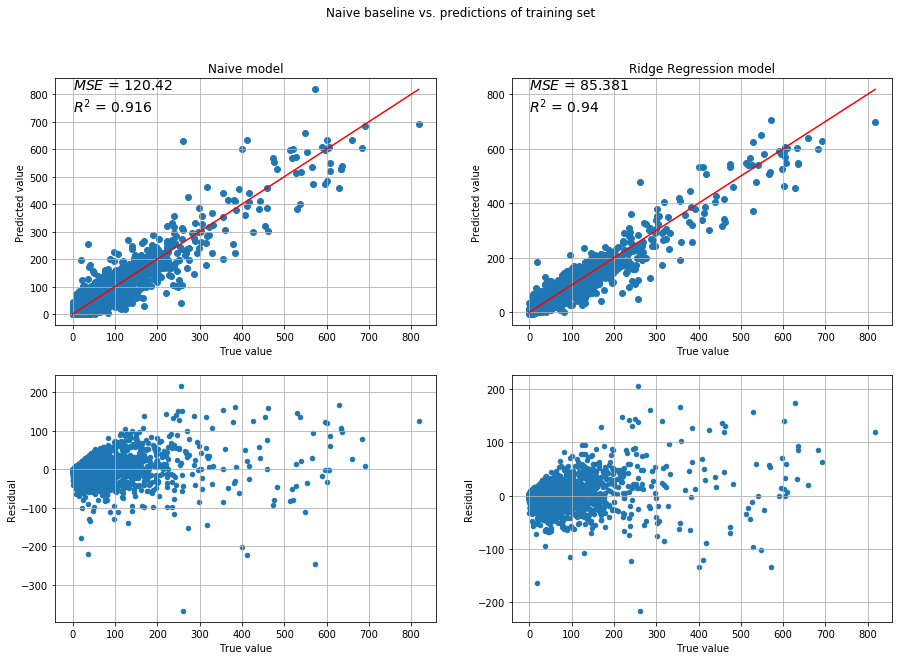

In [12]:
y_predict = ridge.predict(X_regression).ravel()
y_true = y_regression
y_naive = np.concatenate((y_train_naive, y_validate_naive),axis=0)
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='regression_train_performance.jpg')

Now that everything has been validated, we may perform the final prediction on the hold-out set. The idea here is to not use this to tune the model. I.e. this is the point of no return, otherwise I risk introducing bias.

There were 11 negative predictions
1-step MSE [Naive, Ridge regression model] = [441.6371257671233,254.18580672991652]
1-step R^2 [Naive, Ridge regression model] = [0.8302251301912098,0.9022805361257239]


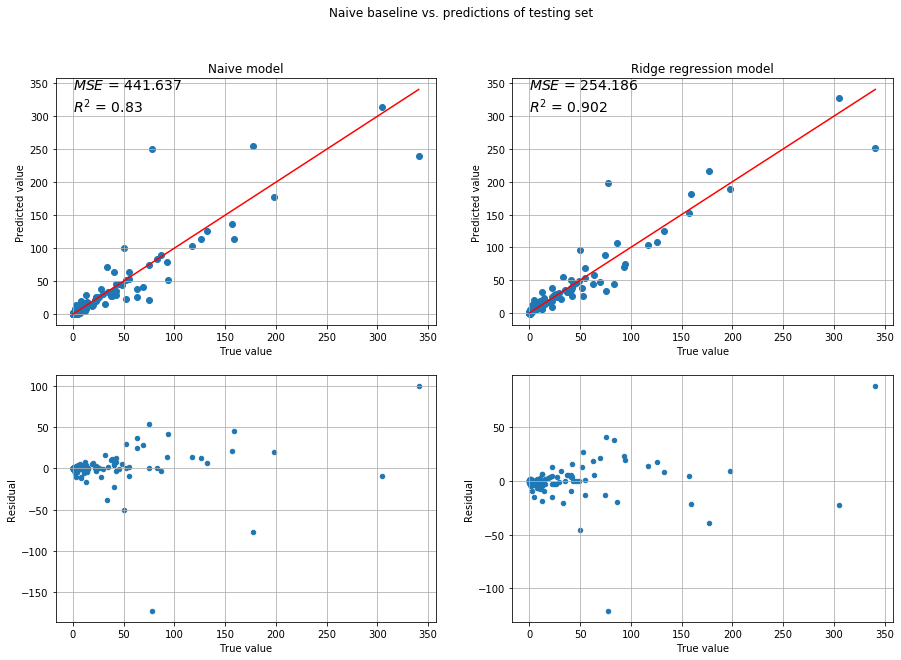

In [13]:
y_true = y_regression_test
y_naive = y_test_naive
y_predict = ridge.predict(X_regression_test).ravel()

# model_analysis(y_regression_test, y_test_naive, y_predict_test, n_countries, title='Ridge', suptitle='Scaled predictor test set performance')
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge regression model',
               suptitle='Naive baseline vs. predictions of testing set',
              figname='regression_test_performance.jpg')

The model doesn't perform exceptionally better, but I suspect the naive baseline's performance is due to the 1-day forecasting interval. The future work would be to see how these results generalize to longer forecasting intervals. 

Sort the ridge regression coefficients. There are only 14 features, but 28 days worth such that there are a total of $14*28 = 392$ dimensions. By taking modulo 14, we can see the feature that the column originates from.

In [14]:
model_data.columns[np.mod(np.argsort(np.abs(ridge.coef_)), 14)][:25]

Index(['new_cases_per_million_rolling_mean_14',
       'government_response_index_rolling_mean_3',
       'government_response_index_rolling_mean_14',
       'government_response_index_rolling_mean_7', 'time_index', 'time_index',
       'time_index', 'time_index', 'time_index', 'time_index', 'time_index',
       'time_index', 'time_index', 'time_index', 'time_index', 'time_index',
       'time_index', 'time_index', 'time_index', 'time_index', 'time_index',
       'time_index', 'time_index', 'time_index', 'time_index'],
      dtype='object')